In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


100% 32.7M/32.7M [00:00<00:00, 27.3MB/s]

Archive:  soccer.zip
  inflating: database.sqlite         
['overall_rating', 'potential', 'preferred_foot', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.688696	valid_1's auc: 0.687535
[100]	training's auc: 0.705957	valid_1's auc: 0.703503
[150]	training's auc: 0.717948	valid_1's auc: 0.714001
[200]	training's auc: 0.728377	valid_1's auc: 0.723483
[250]	training's auc: 0.737201	valid_1's auc: 0.730923
[300]	training's auc: 0.744521	valid_1's a

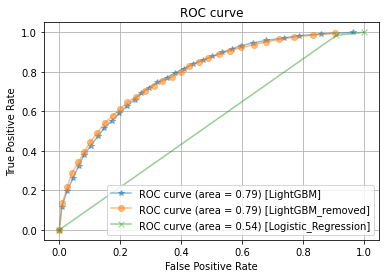

In [2]:
import pandas as pd
import re
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.metrics import classification_report
# LightGBMを使うためにインポート
import lightgbm as lgb
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# sqlite3のデータを扱うために必要
import sqlite3
# データの準備
def prepare():
    # サッカー選手の属性データ
    !kaggle datasets download -d hugomathien/soccer
    !unzip soccer.zip
    # SQLite3形式で提供されているため、必要なデータを
    # 検索式で取得してDataFrameに格納する
    db_name = 'database.sqlite'
    con = sqlite3.connect(db_name)
    c = con.execute('SELECT * FROM Player_Attributes') 
    fields = list(map(lambda x: x[0], c.description)) 
    fields = list(
             filter(
             lambda x: re.match(r'.*(id|date|rate)$', x) \
                                       == None , fields))
    print(fields)
    # SELECT結果をDataFrameに格納
    fstr = ', '.join(fields) 
    df = pd.read_sql_query(
         sql=u"SELECT %s FROM Player_Attributes" % \
         fstr, con=con)
    target_field = 'preferred_foot'
    df.dropna(subset=[target_field], inplace=True)
    df[target_field] = \
    df[target_field].map({'left':0, 'right':1}).astype(int)
    return con, fields, df, target_field

# 学習/テストデータを作成
def make_data(df, target_field, flag):
    # flagが1ならば、すべての欠損値を含むデータを削除
    if flag == 1:
      df.dropna(inplace=True)
    train_set, test_set = train_test_split(
            df, train_size = 0.95, random_state = 9)
    X_train = train_set.drop(target_field, axis = 1)
    y_train = train_set[target_field]
    X_test = test_set.drop(target_field, axis = 1)
    y_test = test_set[target_field]
    return X_train, X_test, y_train, y_test

# ROC曲線を描く
def makeGraph(auc, fpr, tpr, clfname):
    markers = {'LightGBM':'*', 
             'LightGBM_removed':'o',
             'Logistic_Regression':'x'}
    # 見やすくするために、fpr, tpr から間引く
    if markers[clfname] in ['*', 'o']:
        idxs = [i for i in range(len(fpr)) if i % 100 == 0]
        fpr = fpr[idxs]
        tpr = tpr[idxs]
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f) [%s]'\
      % (auc, clfname), marker=markers[clfname], alpha=0.5)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

def lightGBM_train(X_train, y_train, X_test, \
                   y_test, X_eval, y_eval, caption):
    # LightGBM用のデータセットに入れる
    lgb_train = lgb.Dataset(X_train, y_train) 
    lgb_eval = lgb.Dataset(X_eval, y_eval, 
                        reference=lgb_train)
    # LightGBMのパラメータ設定 
    params = {
        'objective' : 'binary',
        'metric': 'auc',
        'task' : 'train',
        'boosting_type' : 'gbdt','num_leaves' :6,
        'learning_rate' : 0.05,}

    gbm = lgb.train(params, lgb_train, 
                    valid_sets=(lgb_train, lgb_eval),
                    verbose_eval=50, 
                    num_boost_round=1000,
                    early_stopping_rounds=100)
    # テストデータを用いて予測精度を確認する
    y_pred = gbm.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    print(auc_score)
    makeGraph(auc_score, fpr, tpr, caption)

def main():
    con, fields, df, target_field = prepare()
    flag = 0
    # LightGBMを使って予測モデルを学習する
    # 欠損値は除去しない
    #（ターゲットが欠損しているもののみ除去）
    X_train, X_test, y_train, y_test = make_data(
                             df, target_field, flag)
    X_train, X_eval, y_train, y_eval = train_test_split(
                                       X_train, y_train)
    lightGBM_train(X_train, y_train, X_test, \
                   y_test, X_eval, y_eval, 'LightGBM')
    # 欠損値はすべて削除
    flag = 1
    X_train, X_test, y_train, y_test = make_data(
                           df, target_field, flag)
    X_train, X_eval, y_train, y_eval = train_test_split(
                                       X_train, y_train)
    # 欠損値を除去したデータでLightGBMを使って予測
    lightGBM_train(X_train, y_train, X_test, \
                   y_test, X_eval, y_eval, 'LightGBM_removed')
    
    # ロジスティック回帰モデルを使って予測
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred_lr = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
    auc_score = auc(fpr, tpr)
    print(auc_score)
    makeGraph(auc_score, fpr, tpr, 'Logistic_Regression')
    # ROC曲線のグラフをpngファイル形式で保存
    plt.savefig('prog3-14_fig.png', dpi=500)

if __name__ == '__main__':
    main()
